# Data Science - Social Media Analytics SoSe 24 📊🔍

This notebook represents my submission for the capstone project in Social Media Analytics for the summer semester of 2024.

### Authors 👥
- **Martin Brucker** (942815) 🧑‍💻

**Due**: Sunday, 30 June 2024, 11:59 PM

**Contact Information**: martin.brucker@student.fh-kiel.de 📧

---

# 🚒 Capstone Project - Kiel Fire Departments 🚒

Municipal emergency management is organized decentrally. An important component of non-police emergency management is the fire department. The Kiel fire departments use the program **"fox112"**, which is utilized for booking courses, duty assignments, and general operational planning. The website can be accessed via [fox112](https://kiel.fox112.de/SSL.php).

Data-driven decision-making is becoming increasingly important, and managers are more frequently required to make well-founded decisions. To facilitate a better understanding of the types and locations of emergencies, this notebook provides an in-depth analysis of the structure and operations of the Kiel fire department.

## 📋 Table of Contents:
1. 📥 **Data Acquisition**
2. 🛠️ **Data Preparation**
3. 📊 **Data Visualization**
    - 🕒 **Time-Based Analysis**
    - 🚨 **Emergency-Based Analysis**
    - 📍 **Location-Based Analysis**

---

> **AI-Usage Disclaimer:** This notebook has been written with the assistance of the GitHub Copilot extension for Visual Studio Code.


In [99]:
# Standard library imports
import time
from itertools import combinations

# Third-party imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import geopandas as gpd
import networkx as nx

# Data Acquisition

The page used for scraping present the data in a format like this:

![WebsiteToScrape](https://i.imgur.com/GMzSZ5a.png)

Unfortunately, the individual entries are not well-labeled, making them difficult to access directly. To extract the text from the HTML code, we will extract the columns by directly addressing the specific rows in which they occur. This method is not ideal, as any updates to the data could change the column distribution, requiring adjustments to the code.

In [2]:
def extract_table_data(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')
    date, time, department, category = [], [], [], []

    rows = soup.find_all('tr')[:-1]  # Exclude the last row because it includes the "weitere" button
    for row in rows:
        column = row.find_all('td')
        date.append(column[0].get_text())
        time.append(column[2].get_text()) 
        department.append(column[4].get_text())
        category.append(column[6].get_text())

    # transforming the data into a pandas dataframe
    df = pd.DataFrame({
    'date': date,
    'time': time,
    'department': department,
    'category': category
    })
    return df

### Sleeping Time ⏰

Before starting the web scraping task, it is important to consider the aggressiveness of the scraping algorithm.

The start page of the website displays usage statistics. To avoid getting blocked, it's advisable to introduce a delay between scraping requests. Based on my observations, the website typically handles an average of 20 to 40 requests per minute.

![Average Usage of fox112](https://i.imgur.com/sJIyNIa.png "Average Usage")

To avoid overloading the server and to prevent being blocked, I have limited the number of requests to 4 per minute.


In [4]:
more_pages = True
page = 24
data = pd.DataFrame()

while more_pages == True:
    print(f"Now scraping page {page}")
    url = f"https://kiel.fox112.de/HomePageEinsaetze.php?nextea={page}"
    html = requests.get(url).text

    data = pd.concat([data, extract_table_data(html)])

    # Checking if there are more pages
    if "Es sind keine Einsätze bekannt." in html:
        more_pages = False
    else:
        page += 24

    time.sleep(15) 

Now scraping page 24
Now scraping page 48
Now scraping page 72
Now scraping page 96
Now scraping page 120
Now scraping page 144
Now scraping page 168
Now scraping page 192
Now scraping page 216
Now scraping page 240
Now scraping page 264
Now scraping page 288
Now scraping page 312
Now scraping page 336
Now scraping page 360
Now scraping page 384
Now scraping page 408
Now scraping page 432
Now scraping page 456
Now scraping page 480
Now scraping page 504
Now scraping page 528
Now scraping page 552
Now scraping page 576
Now scraping page 600
Now scraping page 624
Now scraping page 648
Now scraping page 672
Now scraping page 696
Now scraping page 720
Now scraping page 744
Now scraping page 768
Now scraping page 792
Now scraping page 816
Now scraping page 840
Now scraping page 864
Now scraping page 888
Now scraping page 912
Now scraping page 936
Now scraping page 960
Now scraping page 984
Now scraping page 1008
Now scraping page 1032
Now scraping page 1056
Now scraping page 1080
Now scrapi

### Scraping End Condition

Ending conditions are crucial in web scraping to instruct the algorithm when to stop in a sophisticated manner, preventing excessive loads on the queried server and minimizing the risk of detection.

When scraping data, it's necessary to determine when to halt the process. In some cases, when no further data is available, the server may return an HTML document indicating that no more information is present. For instance, the server might return a message like "Es sind keine Einsätze bekannt" (translated: "No operations are known").

![No Data Available](https://i.imgur.com/uPZ8tZI.png)

In [4]:
# to save the dataframe into a persistant sherable file:
# data.to_csv('data/kiel_fire_department.csv', index=False)

# to read the data from the file:
# data = pd.read_csv('data/kiel_fire_department.csv')

# Data Preperation

In [5]:
# the concat function messes with he dataframe index, so we need to reset it
data.reset_index(drop=True, inplace=True)

In [6]:
# combine date DD.MM.YYYY and time columns into a single datetime column
data['datetime'] = pd.to_datetime(data["date"] + " " + data["time"], format='%d.%m.%Y %H:%M')

# drop the date and time columns
df = data.drop(columns=['date', 'time'])

In [7]:
# make to category data type
df['category'] = df['category'].astype('category')
df["department"] = df["department"].astype('category')

In [8]:
# create a week and year column
df["week"] = df["datetime"].dt.isocalendar().week
df["year"] = df["datetime"].dt.year

In [9]:
# Exclude Löschzug Gefahrgut and BF Kiel from the analysis:
# 1. Löschzug Gefahrgut is a special task force and not a regular fire department, so it will be excluded.
# 2. BF Kiel is the professional fire department of Kiel. We will also exclude it since the fox112 website changed the way they display the data.

# Note: For an analysis of BF Kiel, data must be scraped from their specific fox112 site: bf-kiel.fox112.de/

# Filter the dataframe to keep only the volunteer fire departments
df = df[df["department"] != "Löschzug Gefahrgut"]
df = df[df["department"] != "BF Kiel"]


In [10]:
# transform the fire station label into a usefull information by removing the "FF" part in the label
df["department"] = df["department"].str.replace("FF ", "")

preparing everything for a later visualisation with a map of kiel and the respective emergencies

We downloaded a geojson document of the kieler districts from open street map.

The city districts of kiel does not match the ausrückegebiet of the fire departments of kiel shown in the picture below, so we have to edit the distrits to fit with the ausgrücke gebiet of kiel.

a deeper look into the department districsts can be found here: https://www.feuerwehr-schilksee.de/joomla/index.php/einsatzgebiet

In [86]:
# loading a geojson file with the districts of Kiel to make later visualisations possible
districtsKiel = gpd.read_file('data/districts.geojson')

In [87]:
districtsKiel["name"].unique()

array(['Ravensberg', 'Blücherplatz', 'Schreventeich',
       'Neumühlen-Dietrichsdorf', 'Brunswik', 'Düsternbrook', 'Wik',
       'Exerzierplatz', 'Rönne', 'Moorsee', 'Russee', 'Mettenhof',
       'Hasseldieksdamm', 'Suchsdorf', 'Damperhof', 'Altstadt',
       'Vorstadt', 'Meimersdorf', 'Südfriedhof', 'Hassee', 'Wellsee',
       'Gaarden-Süd/Kronsburg', 'Holtenau', 'Schilksee', 'Pries',
       'Friedrichsort', 'Elmschenhagen', 'Ellerbek', 'Gaarden-Ost',
       'Wellingdorf'], dtype=object)

In [90]:
# Mapping Dictionary
merge_dict = {
    'Gaarden': ['Südfriedhof', 'Gaarden-Süd/Kronsburg', 'Altstadt', 'Vorstadt', 'Damperhof', 'Brunswik', 'Exerzierplatz', 'Gaarden'],
    'Russee': ['Russee', 'Hassee', 'Mettenhof', 'Hasseldieksdamm', 'Schreventeich'],
    'Meimersdorf': ['Meimersdorf'],
    'Moorsee': ['Moorsee'],
    'Rönne': ['Rönne'],
    'Wellsee': ['Wellsee'],
    'Elmschenhagen': ['Elmschenhagen', 'Ellerbek', 'Gaarden-Ost'],
    'Suchsdorf': ['Suchsdorf', 'Wik', 'Ravensberg', 'Blücherplatz', 'Düsternbrook'],
    'Schilksee': ['Schilksee', 'Pries', 'Friedrichsort', 'Holtenau'],
    'Dietrichsdorf': ['Dietrichsdorf','Wellingdorf', 'Neumühlen-Dietrichsdorf']
}

In [91]:
merged_districts = []
for new_district, old_districts in merge_dict.items():
    # Filter the districts to merge
    to_merge = districtsKiel[districtsKiel['name'].isin(old_districts)]
    # Perform the merge
    merged_polygon = to_merge.unary_union
    merged_districts.append({
        'name': new_district,
        'geometry': merged_polygon
    })

merged_gdf = gpd.GeoDataFrame(merged_districts, crs=districtsKiel.crs)

In [92]:
# Count the number of events per new district
events_per_district = df.groupby('department').size().reset_index(name='count')

# Map the events to the new district names
district_mapping = {old_district: new_district for new_district, old_districts in merge_dict.items() for old_district in old_districts}
events_per_district['department'] = events_per_district['department'].map(district_mapping)

# Group by the new district names
events_per_new_district = events_per_district.groupby('department').sum().reset_index()

In [94]:
merged_gdf = merged_gdf.merge(events_per_new_district, left_on='name', right_on='department', how='left')
merged_gdf['count'] = merged_gdf['count'].fillna(0)  # Fill NaN values with 0

# Data Visualisation

To gain further insides into the emergency departments and statistics we are going to take a deeper look at 3 main analysis parts:

- analysis of the incidents over a time series, have they declined, are there less fires since smoke detectors got mendatory?
- taking a deeper look of what category of emergencys are, they are split into ['Brand oder Explosion', 'Technische Hilfe', 'Sonstiger Einsatz', 'Fehlalarm']
- connections between fire-departments, if they are alarmed to the same emergency 

## Time-Based Analysis

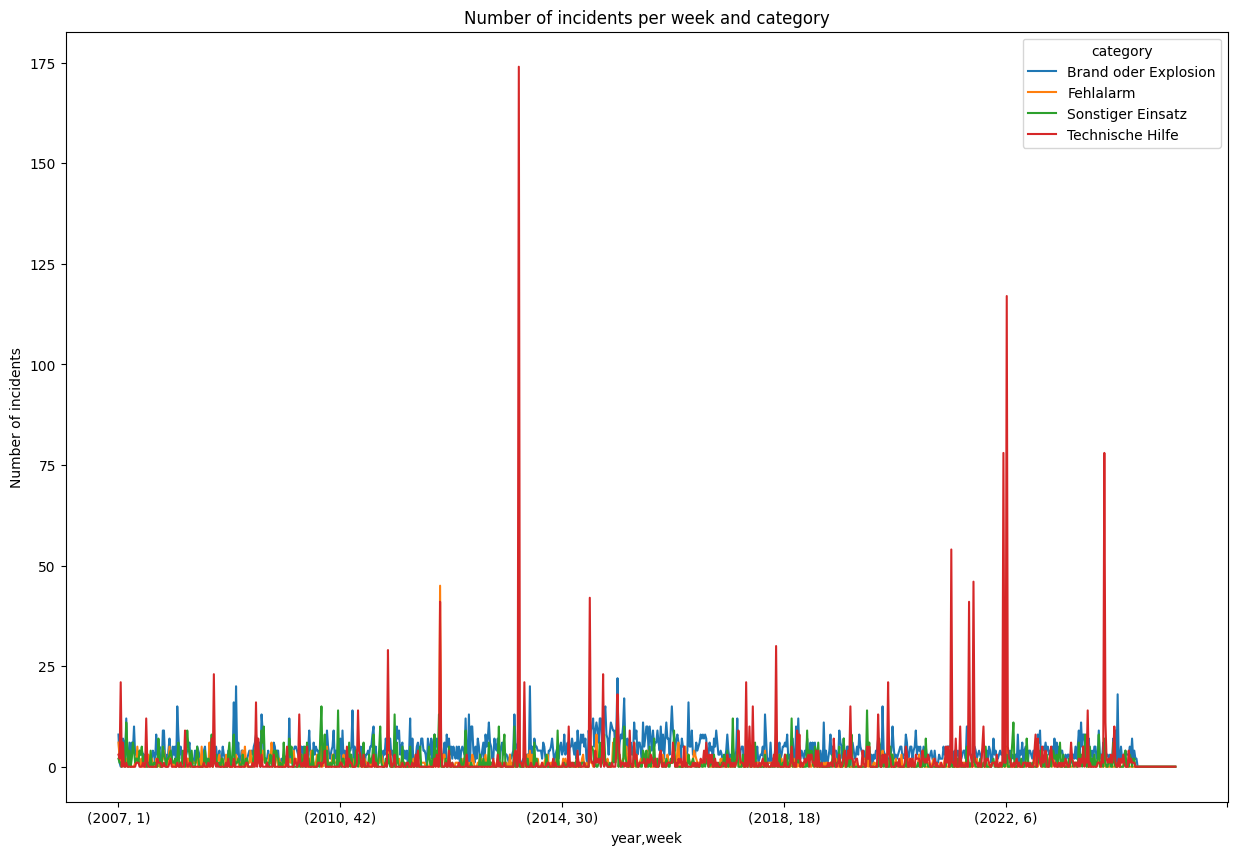

In [17]:
# plot the number of incidents per week and category
df.groupby(["year", "week", "category"], observed=False).size().unstack().plot(kind='line', figsize=(15, 10))
plt.title("Number of incidents per week and category")
plt.ylabel("Number of incidents")
plt.show()

In [18]:
# analysing the week with the most incidents
df.groupby(["year", "week"]).size().sort_values(ascending=False).head(5)

year  week
2013  44      188
2022  7       127
2012  26      101
2023  42       93
2022  4        87
dtype: int64

As might be expected, we can draw real-life correlations between the data and harsh weather conditions:

<img src="https://i.imgur.com/g2A0PSf.png" alt="Text" width="400">
<img src="https://i.imgur.com/xNuwijs.png" alt="Text2" width="400">


## Impact of Making Smoke Detectors Mandatory

Since January 1, 2011, smoke detectors have been mandatory in households in Schleswig-Holstein. [Read more here](https://www.rauchmelder-lebensretter.de/rauchmelderpflicht/).

An interesting question to explore is whether there has been a significant reduction in fire incidents since 2011. To address this, we will conduct a hypothesis test.

Our null hypothesis (H₀) is that there has been no reduction in the number of fire incidents since the implementation of mandatory smoke detectors in 2011.


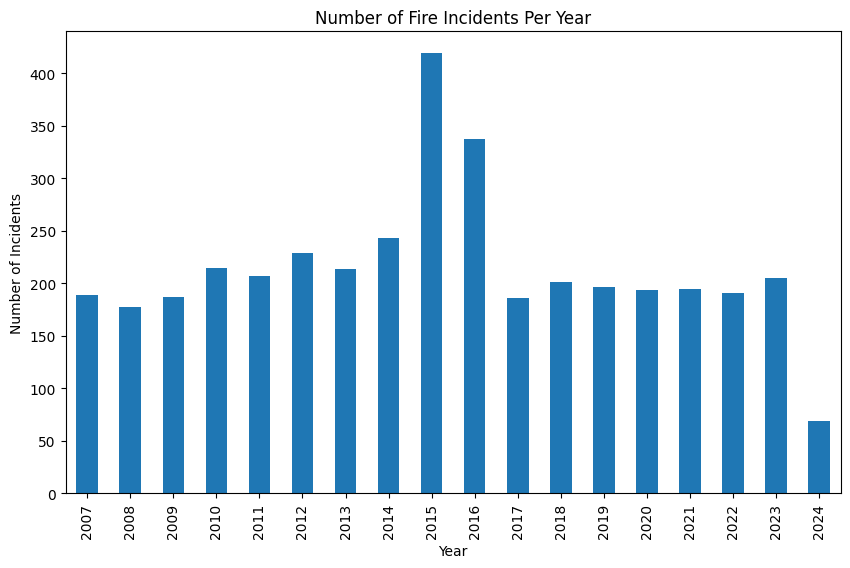

In [19]:
### since 2011 smokedetectors are mandatory in Schleswig-Holstein we will check if the number of fire incidents has decreased
# Filter for 'Brand oder Explosion' incidents
fire_incidents = df[df['category'] == 'Brand oder Explosion']

# Group by year and count incidents
fire_incidents_per_year = fire_incidents.groupby('year').size()

# Plot the data
plt.figure(figsize=(10, 6))
fire_incidents_per_year.plot(kind='bar')
plt.title('Number of Fire Incidents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

In [21]:
from scipy.stats import ttest_ind

# Group by year and count incidents
fire_incidents_per_year = fire_incidents.groupby('year').size()

# Split the data into two groups: before 2011 and from 2011 onwards
before_2011 = fire_incidents_per_year[fire_incidents_per_year.index < 2011]
after_2011 = fire_incidents_per_year[fire_incidents_per_year.index >= 2011]

# Perform the two-sample t-test
t_stat, p_value = ttest_ind(before_2011, after_2011, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -1.252495017087808
P-value: 0.22886089427074732


Since the p-value of 0.23 is greater than the commonly used alpha level of 0.05, we do not reject the null hypothesis. Therefore, there is no statistically significant reduction in fire incidents following the mandatory implementation of smoke detectors in Schleswig-Holstein in 2011.

>Note: This analysis only considers the number of incidents that resulted in a fire department response. The number of incidents could decrease if people detect fires earlier and extinguish them without involving the fire department. Additionally, this data does not account for lives saved or injuries prevented.

## Emergency per department

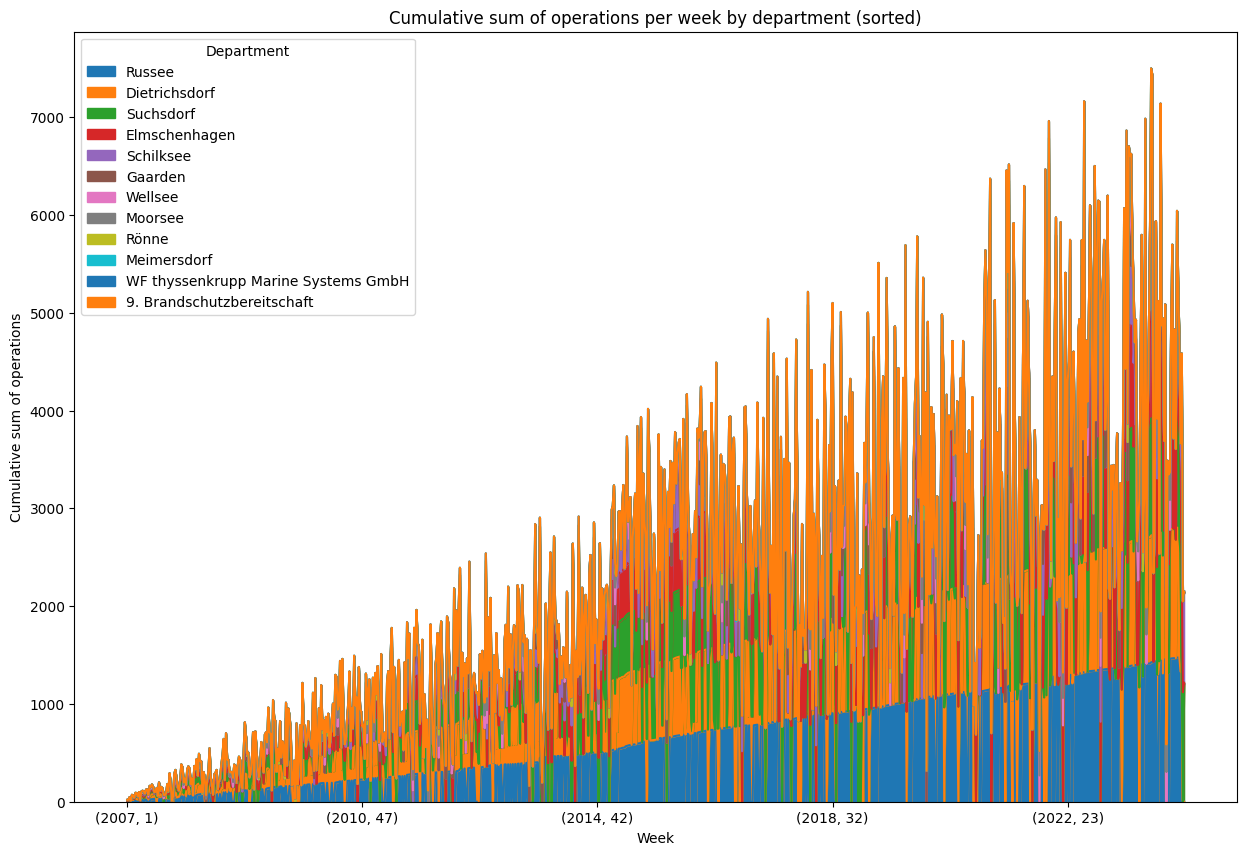

In [22]:
# Calculate the cumulative sum of operations per department per week
department_weekly_cumulative_sum = df.groupby(["year", "week", "department"], observed=False).size().unstack().cumsum()

# Calculate the total number of operations for each department
department_totals = department_weekly_cumulative_sum.sum(axis=0)

# Sort departments in descending order by total operations
sorted_departments = department_totals.sort_values(ascending=False).index

# Plot the cumulative sum of operations per week for each department in sorted order
department_weekly_cumulative_sum[sorted_departments].plot(kind='area', figsize=(15, 10))
plt.title("Cumulative sum of operations per week by department (sorted)")
plt.ylabel("Cumulative sum of operations")
plt.xlabel("Week")
plt.legend(title="Department")


## Location-Based Analysis

To gain deeper insights into the connections between fire departments we can look at the count of emergencys the departments have together.
This data can be used to plan trainings events together or use this as a base to establish further connections between the departments so that in the future in case of an incident the fireifghts work more seamlesly together.

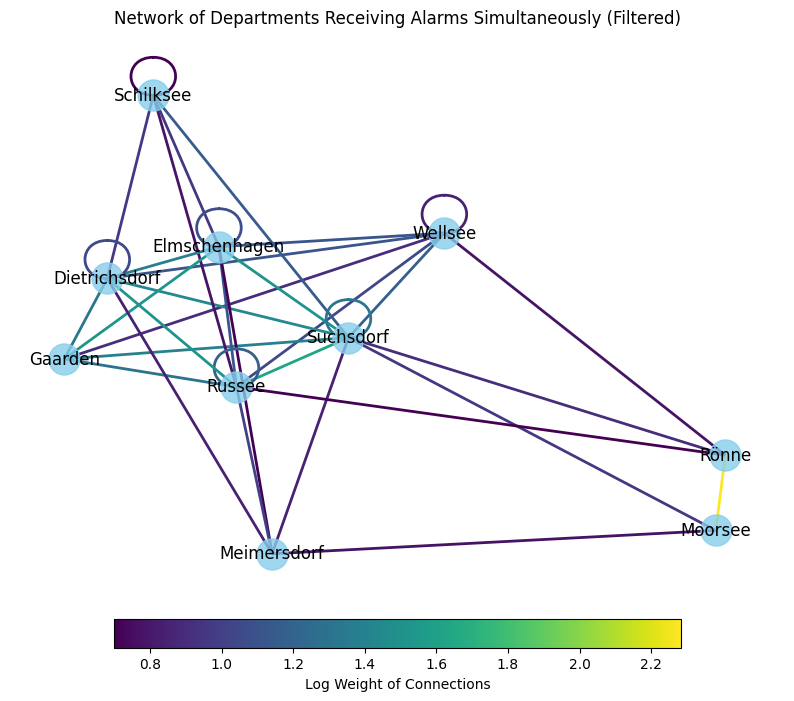

In [32]:
# Create an empty graph
G = nx.Graph()

# Group by datetime and find departments receiving alarms at the same time
for _, group in df.groupby('datetime'):
    departments = group['department'].tolist()
    # Add edges for each pair of departments receiving alarms simultaneously
    for dept1, dept2 in combinations(departments, 2):
        if G.has_edge(dept1, dept2):
            G[dept1][dept2]['weight'] += 1
        else:
            G.add_edge(dept1, dept2, weight=1)

# Set a minimum weight threshold
min_weight_threshold = 5

# Remove edges with weight below the threshold
edges_to_remove = [(dept1, dept2) for dept1, dept2, weight in G.edges(data='weight') if weight < min_weight_threshold]
G.remove_edges_from(edges_to_remove)

# Get edge weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Apply logarithmic transformation to the weights
log_weights = np.log10(weights)

# Normalize log weights for colormap
norm = plt.Normalize(vmin=min(log_weights), vmax=max(log_weights))
cmap = plt.cm.viridis

# Draw the network graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.8)

# Draw edges with color based on log-transformed weight
for edge, log_weight in zip(edges, log_weights):
    dept1, dept2, data = edge
    nx.draw_networkx_edges(G, pos, edgelist=[(dept1, dept2)], width=2, edge_color=[cmap(norm(log_weight))])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Log Weight of Connections')

# Show plot
plt.title('Network of Departments Receiving Alarms Simultaneously (Filtered)')
plt.axis('off')
plt.show()

since the firedepartment moorsee and rönne have a very high connection with a weight of 192 the color weiths betwene the nodes have been displayed in a logarithmic scale to also make a visualisation between smaller connections possible.

We can see that there is a inner cirle between the five fire departments of Dietrichsdorf, Elmschenhagen, Russee, Suchsdorf and Gaarden.

## Fire operations on a map

In [98]:
# Create the Altair chart
chart = alt.Chart(merged_gdf).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
    color=alt.Color('count:Q', scale=alt.Scale(scheme='inferno'), title='Number of Events'),
    tooltip=['name:N', 'count:Q']
).properties(
    width=400,
    height=400,
    title='Events per Fire Department Area in Kiel, Germany'
).project(
    type='identity', 
    reflectY=True
)

chart

alt.Chart(...)